In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [4]:
# 制作数据集
class MyData(Dataset): # 继承Dataset 类
    def __init__(self, filepath):
        df = pd.read_csv(filepath, index_col=0) # 导入数据
        arr = df.values # 对象退化为数组
        arr = arr.astype(np.float32) # 转为float32 类型数组
        ts = torch.tensor(arr) # 数组转为张量
        ts = ts.to('cuda') # 把训练集搬到cuda 上
        self.X = ts[ : , : -1 ] # 前8 列为输入特征
        self.Y = ts[ : , -1 ].reshape((-1,1)) # 后1 列为输出特征
        self.len = ts.shape[0] # 样本的总数
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [5]:
# 划分训练集与测试集
Data = MyData('Data.csv')
train_size = int(len(Data) * 0.7) # 训练集的样本数量
test_size = len(Data) - train_size # 测试集的样本数量
train_Data, test_Data = random_split(Data, [train_size, test_size])

In [6]:
# 批次加载器
train_loader = DataLoader(dataset=train_Data, shuffle=True, batch_size=128) # shuffle洗牌
test_loader = DataLoader(dataset=test_Data, shuffle=False, batch_size=64) # 测试集就不需要洗牌了

In [7]:
# 搭建神经网络
class DNN(nn.Module):
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential( # 按顺序搭建各层
        nn.Linear(8, 32), nn.Sigmoid(), # 第1 层：全连接层
        nn.Linear(32, 8), nn.Sigmoid(), # 第2 层：全连接层
        nn.Linear(8, 4), nn.Sigmoid(), # 第3 层：全连接层
        nn.Linear(4, 1), nn.Sigmoid() # 第4 层：全连接层
        )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [8]:
model = DNN().to('cuda:0') # 创建子类的实例，并搬到GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [9]:
# 损失函数的选择
loss_fn = nn.BCELoss(reduction='mean')

In [10]:
# 优化算法的选择
learning_rate = 0.005 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

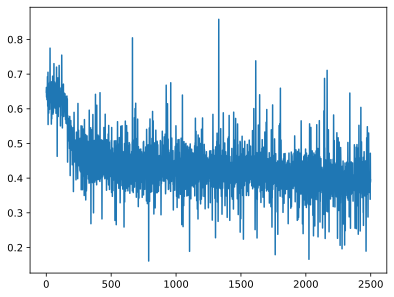

In [11]:
# 训练网络
epochs = 500
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的x 与y
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [12]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的x 与y
        Pred = model(x) # 一次前向传播（小批量）
        Pred[Pred>=0.5] = 1
        Pred[Pred<0.5] = 0
        correct += torch.sum( (Pred == y).all(1) )
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 71.0526351928711 %
